## Ciphersuites: distance to known libraries

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm
import sqlite3
import time
import hashlib
import re
import datetime
import matplotlib.pyplot as plt
import matplotlib
import editdistance
import functools
from IPython.display import clear_output
import seaborn as sns
import random
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
from __future__ import division
import math
from bisect import bisect_left
from collections import namedtuple

### Helper functions and definitions

In [2]:
ciphermap = pd.read_csv("../datasets/ciphersuite_map.csv").rename(columns={"cipher_x": "ciphersuite"})

secure_lis = ['dhe_rsa', 'dhe_dss', 'dhe_psk', 'ecdhe_psk', 'ecdhe_ecdsa', \
              'aes_128_gcm', 'aes_256_gcm', 'aes_128_ccm_8', 'aes_256_ccm_8', 'aes_128_ccm', 'aes_256_ccm', \
              'camellia_128_gcm', 'camellia_256_gcm', 'aria_128_gcm', 'aria_256_gcm', 'chacha20_poly1305', \
              'sha256', 'sha384', \
              'fallback', 'secure_renego', '13', 'secure_renego', 'fallback_scsv', 'scsv']
weak_lis = ['rsa', 'ecdh_rsa', 'ecdh_ecdsa', 'dh_rsa', 'psk', 'dh_dss', 'krb5', 'srp_sha_rsa', 'srp_sha_dss', 'srp_sha', \
            'aes_128_cbc', 'aes_256_cbc', '3des_ede_cbc', 'camellia_128_cbc', 'camellia_256_cbc', 'aria_128_cbc', 'aria_256_cbc', \
            'seed_cbc', 'idea_cbc', 'sha']
insecure_lis = ['dh_anon', 'krb5_export', 'ecdh_anon', 'null', 'rc4_128', 'rc4_40', 'rc2_cbc_40', 'des_cbc', 'des40_cbc', \
                'des_cbc_40', 'md5']



### get rid of duplicated val at depth ###
def set_at_depth(lst, depth):
    ans = set()
    for v in lst[:depth]:
        if isinstance(v, set):
            # put v into the ans set
            ans.update(v)
        else:
            ans.add(v)
    return ans


def raw_overlap(list1, list2, depth):
    """Overlap as defined in the article.
    """
    set1, set2 = set_at_depth(list1, depth), set_at_depth(list2, depth)
    return len(set1.intersection(set2)), len(set1), len(set2)


def overlap(list1, list2, depth):
    """Overlap which accounts for possible ties.
    This isn't mentioned in the paper but should be used in the ``rbo*()``
    functions below, otherwise overlap at a given depth might be > depth which
    inflates the result.
    There are no guidelines in the paper as to what's a good way to calculate
    this, but a good guess is agreement scaled by the minimum between the
    requested depth and the lengths of the considered lists (overlap shouldn't
    be larger than the number of ranks in the shorter list, otherwise results
    are conspicuously wrong when the lists are of unequal lengths -- rbo_ext is
    not between rbo_min and rbo_min + rbo_res.
    >>> overlap("abcd", "abcd", 3)
    3.0
    >>> overlap("abcd", "abcd", 5)
    4.0
    >>> overlap(["a", {"b", "c"}, "d"], ["a", {"b", "c"}, "d"], 2)
    2.0
    >>> overlap(["a", {"b", "c"}, "d"], ["a", {"b", "c"}, "d"], 3)
    3.0
    """
    return agreement(list1, list2, depth) * min(depth, len(list1), len(list2))
    # NOTE: comment the preceding and uncomment the following line if you want
    # to stick to the algorithm as defined by the paper
    # return raw_overlap(list1, list2, depth)[0]


def agreement(list1, list2, depth):
    """Proportion of shared values between two sorted lists at given depth.
    >>> _round(agreement("abcde", "abdcf", 1))
    1.0
    >>> _round(agreement("abcde", "abdcf", 3))
    0.667
    >>> _round(agreement("abcde", "abdcf", 4))
    1.0
    >>> _round(agreement("abcde", "abdcf", 5))
    0.8
    >>> _round(agreement([{1, 2}, 3], [1, {2, 3}], 1))
    0.667
    >>> _round(agreement([{1, 2}, 3], [1, {2, 3}], 2))
    1.0
    """
    len_intersection, len_set1, len_set2 = raw_overlap(list1, list2, depth)
    return 2 * len_intersection / (len_set1 + len_set2)


def cumulative_agreement(list1, list2):
    lis1_copy = list1.copy()
    lis2_copy = list2.copy() 
    depth = max(len(list1), len(list2))
    
    if len(lis1_copy) < depth:
        for n in range(0, depth - len(lis1_copy)):
            lis1_copy.append(0)
    elif len(lis2_copy) < depth:
        for n in range(0, depth - len(lis2_copy)):
            lis2_copy.append(0)
    return list(agreement(lis1_copy, lis2_copy, d) for d in range(1, depth + 1))


def average_overlap(list1, list2, depth=None):
    """Calculate average overlap between ``list1`` and ``list2``.
    >>> _round(average_overlap("abcdefg", "zcavwxy", 1))
    0.0
    >>> _round(average_overlap("abcdefg", "zcavwxy", 2))
    0.0
    >>> _round(average_overlap("abcdefg", "zcavwxy", 3))
    0.222
    >>> _round(average_overlap("abcdefg", "zcavwxy", 4))
    0.292
    >>> _round(average_overlap("abcdefg", "zcavwxy", 5))
    0.313
    >>> _round(average_overlap("abcdefg", "zcavwxy", 6))
    0.317
    >>> _round(average_overlap("abcdefg", "zcavwxy", 7))
    0.312
    """
    depth = min(len(list1), len(list2)) if depth is None else depth
    return sum(cumulative_agreement(list1, list2, depth)) / depth



def component_alg(liblis, iotlis):
    dist = 0
    liblis_keyexchange = set()
    liblis_cipher = set()
    liblis_mac = set()
    iotlis_keyexchange = set()
    iotlis_cipher = set()
    iotlis_mac = set()
    
    for code in liblis:
        code_row = ciphermap.loc[ciphermap['code_base10'] == code]
        if code_row.empty:
            continue
        code_keyexchange = code_row['key_exchange'].item().split("tls_")[-1]
        code_cipher = code_row['cipher'].item()
        code_mac = code_row['mac'].item()
        
        liblis_keyexchange.add(code_keyexchange)
        liblis_cipher.add(code_cipher)
        liblis_mac.add(code_mac)
    
    for code in iotlis:
        code_row = ciphermap.loc[ciphermap['code_base10'] == code]
        if code_row.empty:
            continue
        code_keyexchange = code_row['key_exchange'].item().split("tls_")[-1]
        code_cipher = code_row['cipher'].item()
        code_mac = code_row['mac'].item()
        
        iotlis_keyexchange.add(code_keyexchange)
        iotlis_cipher.add(code_cipher)
        iotlis_mac.add(code_mac)
        
    iot_parkeyexchange = list(iotlis_keyexchange - iotlis_keyexchange.intersection(liblis_keyexchange))
    for keyexchange_method in iot_parkeyexchange:
        if keyexchange_method in secure_lis:
            dist += 0
        elif keyexchange_method in weak_lis:
            dist += 0.5
        elif keyexchange_method in insecure_lis:
            dist += 1
        
    iot_parcipher = list(iotlis_cipher - iotlis_cipher.intersection(liblis_cipher))
    for cipher_method in iot_parcipher:
        if cipher_method in secure_lis:
            dist += 0
        elif cipher_method in weak_lis:
            dist += 0.5
        elif cipher_method in insecure_lis:
            dist += 1
    
    iot_parmac = list(iotlis_mac - iotlis_mac.intersection(liblis_mac))
    for mac_method in iot_parmac:
        if mac_method in secure_lis:
            dist += 0
        elif mac_method in weak_lis:
            dist += 0.5
        elif mac_method in insecure_lis:
            dist += 1
            
    return dist

In [3]:
grease_cipher = ['0x0a0a', '0x1a1a', '0x2a2a', '0x3a3a', '0x4a4a', '0x5a5a', \
                 '0x6a6a', '0x7a7a', '0x8a8a', '0x9a9a', '0xaaaa', '0xbaba', \
                 '0xcaca', '0xdada', '0xeaea', '0xfafa']

In [4]:
def removing_grease(ciphercode_lis):
    updated_cipherlis = []
    for ciphercode in ciphercode_lis:
        if ciphercode not in grease_cipher:
            updated_cipherlis.append(ciphercode)
    return updated_cipherlis

In [5]:
def simi_computing(ins_lis, std_nestlis):
    simi_score = []
    simi_idx = -1
    simi_max = 0
    
    for std_lis in std_nestlis:
        inslis_copy = ins_lis.copy()
        stdlis_copy = std_lis.copy()
        
        if len(inslis_copy) < len(stdlis_copy):
            for n in range(0, len(stdlis_copy) - len(inslis_copy)):
                inslis_copy.append(0)
        elif len(stdlis_copy) < len(inslis_copy):
            for n in range(0, len(inslis_copy) - len(stdlis_copy)):
                stdlis_copy.append(0)
        
        #rbo_score.append(rbo(inslis_copy, stdlis_copy, p).ext)      
        o_set = set(stdlis_copy)
        i_set = set(inslis_copy)
        jaccard = len(o_set & i_set) * 1.0 / len(o_set | i_set)
        simi_score.append(jaccard)
        
    simi_max = max(simi_score)
    simi_idx = simi_score.index(max(simi_score))
    return [simi_idx, simi_max]

In [6]:
secure_lis = ['dhe_rsa', 'dhe_dss', 'dhe_psk', 'ecdhe_psk', 'ecdhe_ecdsa', \
              'aes_128_gcm', 'aes_256_gcm', 'aes_128_ccm_8', 'aes_256_ccm_8', 'aes_128_ccm', 'aes_256_ccm', \
              'camellia_128_gcm', 'camellia_256_gcm', 'aria_128_gcm', 'aria_256_gcm', 'chacha20_poly1305', \
              'sha256', 'sha384']

In [7]:
ignore_alg = ['fallback', 'secure_renego', '13', 'secure_renego', 'fallback_scsv', 'scsv']

In [8]:
def finding_algorithm(keyexchange_set, cipher_set, mac_set, cipher_code):
    code_row = ciphermap.loc[ciphermap['code_base10'] == cipher_code]
    if code_row.empty:
        pass
    else:
        code_keyexchange = code_row['key_exchange'].item().split("tls_")[-1]
        code_cipher = code_row['cipher'].item()
        code_mac = code_row['mac'].item()

        if code_keyexchange not in ignore_alg:
            keyexchange_set.add(code_keyexchange)
        if code_cipher not in ignore_alg:
            cipher_set.add(code_cipher)
        if code_mac not in ignore_alg:
            mac_set.add(code_mac)
    
    return keyexchange_set, cipher_set, mac_set

In [9]:
def is_similar(lib_set, iot_set, component):
    ### This is currently only for CIPHER and MAC compoents ###
    if component == "cipher":
        iot_cipher = set()
        lib_cipher = set()
        
        for cipher_code in list(iot_set):        
            if cipher_code.startswith("aes") or cipher_code.startswith("camellia") or cipher_code.startswith("aria") or cipher_code.startswith("3des"):
                cipher_alg = cipher_code.split("_", 2)[0] + "_" + cipher_code.split("_", 2)[2]
                iot_cipher.add(cipher_alg)
            elif cipher_code.startswith("rc") or cipher_code.startswith("des") or cipher_code.startswith("chacha20"):
                cipher_alg = cipher_code.split("_", 1)[0]
                iot_cipher.add(cipher_alg)
            else:
                iot_cipher.add(cipher_code)
            
        for cipher_code in list(lib_set):
            if cipher_code.startswith("aes") or cipher_code.startswith("camellia") or cipher_code.startswith("aria") or cipher_code.startswith("3des"):
                cipher_alg = cipher_code.split("_", 2)[0] + "_" + cipher_code.split("_", 2)[2]
                lib_cipher.add(cipher_alg)
            elif cipher_code.startswith("rc") or cipher_code.startswith("des") or cipher_code.startswith("chacha20"):
                cipher_alg = cipher_code.split("_", 1)[0]
                lib_cipher.add(cipher_alg)
            else:
                lib_cipher.add(cipher_code)
        
        if iot_cipher.issubset(lib_cipher):
            return True
        else:
            return False
        
    if component == "mac":
        iot_mac = set()
        lib_mac = set()
        
        for mac_code in list(iot_set):
            if mac_code == "sha":
                iot_mac.add("sha1")
            elif mac_code.startswith("sha") and mac_code != "sha":
                iot_mac.add("sha")
            else:
                iot_mac.add(mac_code)
                
        for mac_code in list(lib_set):
            if mac_code == "sha":
                lib_mac.add("sha1")
            elif mac_code.startswith("sha") and mac_code != "sha":
                lib_mac.add("sha")
            else:
                lib_mac.add(mac_code)
                
        if iot_mac.issubset(lib_mac):
            return True
        else:
            return False

In [10]:
def comparing_component(liblis, iotlis):
    liblis_keyexchange = set()
    liblis_cipher = set()
    liblis_mac = set()
    iotlis_keyexchange = set()
    iotlis_cipher = set()
    iotlis_mac = set()
    
    for code in liblis:
        liblis_keyexchange, liblis_cipher, liblis_mac = finding_algorithm(liblis_keyexchange, liblis_cipher, liblis_mac, code)  
    for code in iotlis:
        iotlis_keyexchange, iotlis_cipher, iotlis_mac = finding_algorithm(iotlis_keyexchange, iotlis_cipher, iotlis_mac, code)
    
    # Exact same components: 2.0
    if liblis_keyexchange == iotlis_keyexchange and liblis_cipher == iotlis_cipher and liblis_mac == iotlis_mac:
        return 2
    
    ## Two (out of three) component sets are the same: 2.1
    #elif (liblis_keyexchange != iotlis_keyexchange and liblis_cipher == iotlis_cipher and liblis_mac == iotlis_mac) or \
    #(liblis_keyexchange == iotlis_keyexchange and liblis_cipher != iotlis_cipher and liblis_mac == iotlis_mac) or \
    #(liblis_keyexchange == iotlis_keyexchange and liblis_cipher == iotlis_cipher and liblis_mac != iotlis_mac):
    #    return 2.1
    
    ## One compoent set is the same: 2.2
    #elif (liblis_keyexchange == iotlis_keyexchange and liblis_cipher != iotlis_cipher and liblis_mac != iotlis_mac) or \
    #(liblis_keyexchange != iotlis_keyexchange and liblis_cipher == iotlis_cipher and liblis_mac != iotlis_mac) or \
    #(liblis_keyexchange != iotlis_keyexchange and liblis_cipher != iotlis_cipher and liblis_mac == iotlis_mac):
    #    return 2.2
    
    # Different component sets but similar components: 3.0
    ### Similarity currently only for CIPHER and MAC compoents
    elif (liblis_keyexchange == iotlis_keyexchange and is_similar(liblis_cipher, iotlis_cipher, "cipher") and is_similar(liblis_mac, iotlis_mac, "mac")):
        return 3
        
    # Non-similar components but ALL secure
    #elif all(keyexchange_alg in list(iotlis_keyexchange) for keyexchange_alg in secure_lis) and \
    #      all(cipher_alg in list(iotlis_cipher) for cipher_alg in secure_lis) and \
    #      all(mac_alg in list(iotlis_mac) for mac_alg in secure_lis):
    #      return 4
                    
    return 4

In [11]:
def calculating_dist_simplified(df):
    dist = 0
    cumulis = df['cumulative_agreement']
    
    # exactly match: 0
    if set(cumulis) == {1}:
        return 0
    
    # same set different ordering: 1
    elif cumulis[-1] == 1 and set(cumulis) != {1}:
        return 1
    
    # other situations
    elif cumulis[-1] != 1:
        lib_lis = df['lib_ciphersuites']
        iot_lis = df['updated_codelis']     
        return comparing_component(lib_lis, iot_lis)

### Readin all library fps: keep the latest

In [12]:
lib_df = pd.read_csv('../library_fps/library_fps.csv')

In [13]:
lib_df.shape

(6891, 9)

In [14]:
lib_df = lib_df.drop_duplicates(subset=['cipher_suites'], keep='last').reset_index().drop(columns='index')

In [15]:
lib_df['ciphersuites_lis'] = lib_df['cipher_suites'].apply(lambda x: [int(val) for val in x.split("+")])

In [16]:
std_nestlis = lib_df['ciphersuites_lis'].tolist()

In [17]:
len(std_nestlis)

53

In [18]:
inspector_2014 = pd.read_csv("../datasets/2014dev_fps.csv")

In [19]:
inspector_2014.shape

(11439, 10)

In [20]:
inspector_2014.drop_duplicates(subset=['device_id', 'cipher_suites', 'extension_types', 'tls_version']).shape 

(11439, 10)

In [21]:
inspector_2014['device_id'].value_counts().shape

(2014,)

### Only keep unique {device, ciphersuite list} tuples

In [22]:
inspector_2014drop = inspector_2014.drop_duplicates(subset=['device_id', 'cipher_suites'])

### Process dataframe

In [23]:
inspector_2014drop['cipher_code'] = inspector_2014drop['cipher_code'].apply(lambda x: [int(val) for val in eval(x)])

<ipython-input-23-6e9b4ff328a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspector_2014drop['cipher_code'] = inspector_2014drop['cipher_code'].apply(lambda x: [int(val) for val in eval(x)])


In [24]:
inspector_2014drop['cipher_code_hex'] = inspector_2014drop['cipher_code'].apply(lambda x: [hex(val) for val in x])

<ipython-input-24-5270b6780159>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspector_2014drop['cipher_code_hex'] = inspector_2014drop['cipher_code'].apply(lambda x: [hex(val) for val in x])


### Remove GREASE ciphersuites

In [25]:
inspector_2014drop['updated_hexcodelis'] = inspector_2014drop['cipher_code_hex'].apply(lambda x: removing_grease(x))

<ipython-input-25-e1f6c3d420db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspector_2014drop['updated_hexcodelis'] = inspector_2014drop['cipher_code_hex'].apply(lambda x: removing_grease(x))


In [26]:
inspector_2014drop['updated_codelis'] = inspector_2014drop['updated_hexcodelis']\
                                            .apply(lambda x: [int(val, 16) for val in x])

<ipython-input-26-3ef5b8ba5d8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspector_2014drop['updated_codelis'] = inspector_2014drop['updated_hexcodelis']\


### Calculate Jaccard similarity to all libraries; Pick the most likely library (with the highest similarity)

In [27]:
inspector_2014drop['likely'] = inspector_2014drop['updated_codelis'].apply(lambda x: simi_computing(x, std_nestlis))

<ipython-input-27-63b8abc4ff7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspector_2014drop['likely'] = inspector_2014drop['updated_codelis'].apply(lambda x: simi_computing(x, std_nestlis))


In [28]:
inspector_2014drop['likely_idx'] = inspector_2014drop['likely'].apply(lambda x: x[0])
inspector_2014drop['likely_score'] = inspector_2014drop['likely'].apply(lambda x: float(x[-1]))

<ipython-input-28-e3a2af13dc07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspector_2014drop['likely_idx'] = inspector_2014drop['likely'].apply(lambda x: x[0])
<ipython-input-28-e3a2af13dc07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspector_2014drop['likely_score'] = inspector_2014drop['likely'].apply(lambda x: float(x[-1]))


In [29]:
inspector_2014drop['likely_score'].value_counts().nlargest(3)

1.000000    650
0.454545    419
0.166667    405
Name: likely_score, dtype: int64

<AxesSubplot:>

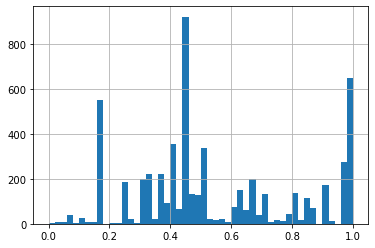

In [30]:
inspector_2014drop['likely_score'].hist(bins=50)

In [31]:
inspector_2014drop.sample(1)

,device_id,cipher_suites,extension_types,tls_version,device_vendor,device_name,library_version,cipher_code,ciphersuite_len,cipher_code_idxl,cipher_code_hex,updated_hexcodelis,updated_codelis,likely,likely_idx,likely_score
7339,s9c386766de,2570+52393+52392+49195+49199+49196+49200+49171+49172+156+157+47+53+10,65281+23+35+13+5+18+16+11+10+21,771,google,chromecast,NaN,"[2570, 52393, 52392, 49195, 49199, 49196, 49200, 49171, 49172, 156, 157, 47, 53, 10]",14,"['2570:0', '52393:1', '52392:2', '49195:3', '49199:4', '49196:5', '49200:6', '49171:7', '49172:8', '156:9', '157:10', '47:11', '53:12', '10:13']","[0xa0a, 0xcca9, 0xcca8, 0xc02b, 0xc02f, 0xc02c, 0xc030, 0xc013, 0xc014, 0x9c, 0x9d, 0x2f, 0x35, 0xa]","[0xa0a, 0xcca9, 0xcca8, 0xc02b, 0xc02f, 0xc02c, 0xc030, 0xc013, 0xc014, 0x9c, 0x9d, 0x2f, 0x35, 0xa]","[2570, 52393, 52392, 49195, 49199, 49196, 49200, 49171, 49172, 156, 157, 47, 53, 10]","[39, 0.3870967741935484]",39,0.387097


### Merge with library version info

In [32]:
lib_df['idx'] = lib_df.index

In [33]:
lib_sub = lib_df[['idx', 'library_version', 'ciphersuites_lis']]\
                 .rename(columns={'ciphersuites_lis':'lib_ciphersuites', \
                                  'library_version':'likely_libver'})

In [34]:
inspector2014_lib = pd.merge(lib_sub, inspector_2014drop.drop(columns=['library_version']), \
                             how='right', right_on='likely_idx', left_on='idx')

In [35]:
inspector2014_lib.sample(1)

,idx,likely_libver,lib_ciphersuites,device_id,cipher_suites,extension_types,tls_version,device_vendor,device_name,cipher_code,ciphersuite_len,cipher_code_idxl,cipher_code_hex,updated_hexcodelis,updated_codelis,likely,likely_idx,likely_score
2983,48,curl_7.65.1_(x86_64-pc-linux-gnu)_libcurl/7.65.1_wolfSSL/3.7.1,"[49196, 49195, 49200, 49199, 159, 158, 52244, 52243, 52245, 49191, 49187, 49192, 49188, 49162, 49161, 49160, 49172, 49171, 49170, 107, 103, 57, 51]",s7a6ce94f1e,49199+49195+49200+49196+158+162+163+159+49191+49187+49171+49161+49192+49188+49172+49162+103+51+64+107+56+57+255,11+10+13+15+13172+16,771,netgear,arlo,"[49199, 49195, 49200, 49196, 158, 162, 163, 159, 49191, 49187, 49171, 49161, 49192, 49188, 49172, 49162, 103, 51, 64, 107, 56, 57, 255]",23,"['49199:0', '49195:1', '49200:2', '49196:3', '158:4', '162:5', '163:6', '159:7', '49191:8', '49187:9', '49171:10', '49161:11', '49192:12', '49188:13', '49172:14', '49162:15', '103:16', '51:17', '64:18', '107:19', '56:20', '57:21', '255:22']","[0xc02f, 0xc02b, 0xc030, 0xc02c, 0x9e, 0xa2, 0xa3, 0x9f, 0xc027, 0xc023, 0xc013, 0xc009, 0xc028, 0xc024, 0xc014, 0xc00a, 0x67, 0x33, 0x40, 0x6b, 0x38, 0x39, 0xff]","[0xc02f, 0xc02b, 0xc030, 0xc02c, 0x9e, 0xa2, 0xa3, 0x9f, 0xc027, 0xc023, 0xc013, 0xc009, 0xc028, 0xc024, 0xc014, 0xc00a, 0x67, 0x33, 0x40, 0x6b, 0x38, 0x39, 0xff]","[49199, 49195, 49200, 49196, 158, 162, 163, 159, 49191, 49187, 49171, 49161, 49192, 49188, 49172, 49162, 103, 51, 64, 107, 56, 57, 255]","[48, 0.6428571428571429]",48,0.642857


In [36]:
inspector2014_lib.loc[inspector2014_lib['lib_ciphersuites'] == inspector2014_lib['updated_codelis']]['device_id'].value_counts().shape

(523,)

### Calculate cumulative agreement for the next distance calculation

In [37]:
inspector2014_lib['cumulative_agreement'] = inspector2014_lib.apply(lambda x: \
                                            cumulative_agreement(x['updated_codelis'], x['lib_ciphersuites']), axis=1)

### Calculate distance to the most likely library

In [38]:
inspector2014_lib['distance_2lib_sim'] = inspector2014_lib.apply(lambda x: calculating_dist_simplified(x), axis=1)

In [39]:
inspector2014_lib['distance_2lib_sim'].value_counts().nlargest(6)

4    2717
3    2086
0     623
2     374
1      27
Name: distance_2lib_sim, dtype: int64

In [40]:
inspector2014_lib.loc[(inspector2014_lib['distance_2lib_sim'] == 3) | \
                      (inspector2014_lib['distance_2lib_sim'] == 4)]['device_id'].value_counts().shape

(1717,)

### Save dataframe for later use

In [41]:
#inspector2014_lib.to_csv("../datasets/2014dev_with_dist2lib.csv")

### Scatter plot

In [42]:
data_drop = inspector2014_lib.loc[inspector2014_lib['distance_2lib_sim'] <= 3][['device_id', 'device_vendor', \
                                                                                'likely_libver', 'device_name', \
                                                                                'distance_2lib_sim']].drop_duplicates()

In [43]:
data_drop.sample(2)

,device_id,device_vendor,likely_libver,device_name,distance_2lib_sim
1524,s3cf230380d,roku,curl-7.34.075_openssl-1.0.2u,ynkh,3
281,s0d2f015cd4,qnap,curl-7.71.068_openssl-1.0.2u,storage,0


In [44]:
data_scatter = data_drop.groupby(['device_vendor', 'likely_libver', 'distance_2lib_sim'])['device_id'].agg('count')\
                        .reset_index(name='count')

In [45]:
data_scatter.shape

(296, 4)

In [46]:
data_scatter.sample(3)

,device_vendor,likely_libver,distance_2lib_sim,count
65,hdhomerun,curl_7.41.0_(x86_64-unknown-linux-gnu)_libcurl/7.41.0_CyaSSL/3.3.0,3,1
210,synology,curl-7.34.075_openssl-1.0.2u,0,19
5,amazon,curl-7.34.075_openssl-1.0.2u,0,5


#### Drop records with unknown devices

In [47]:
data_scatter = data_scatter.loc[data_scatter['device_vendor'] != 'unknown']

In [48]:
data_scatter['likely_libver'].value_counts().shape

(26,)

In [49]:
data_scatter['device_vendor'] = data_scatter['device_vendor'].apply(lambda x: x.capitalize())

#### Renaming

In [50]:
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Lg')] = 'LG'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Directv')] = 'DirecTV'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Dish network')] = 'Dish Network'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Tcl')] = 'TCL'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Tplink')] = 'TP-Link'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Western digital')] = 'Western Digital'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Hp')] = 'HP'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Ihome')] = 'iHome'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Ikea')] = 'IKEA'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Irobot')] = 'iRobot'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Netgear')] = 'NETGEAR'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Qnap')] = 'QNAP'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Sleep number')] = 'Sleep Number'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Echobee')] = 'echobee'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Idevices')] = 'iDevices'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Vmware')] = 'VMware'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Hdhomerun')] = 'HDHomeRun'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Ecobee')] = 'ecobee'
data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Texas instruments')] = 'Texas Instruments'

<ipython-input-50-1130d078174e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Lg')] = 'LG'
<ipython-input-50-1130d078174e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_scatter.device_vendor[data_scatter['device_vendor'].str.contains('Directv')] = 'DirecTV'
<ipython-input-50-1130d078174e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_scatter.devic

In [51]:
data_scatter.loc[data_scatter.likely_libver == "curl-7.71.068_openssl-1.0.2u", "likely_libver"] = "curl 7.71.068 OpenSSL 1.0.2u"
data_scatter.loc[data_scatter.likely_libver == "curl-7.71.073_openssl-1.1.0l", "likely_libver"] = "curl 7.71.073 OpenSSL 1.1.0l"
data_scatter.loc[data_scatter.likely_libver == "curl_7.41.0_(x86_64-unknown-linux-gnu)_libcurl/7.41.0_CyaSSL/3.3.0", "likely_libver"] = \
                                               "curl 7.41.0 CyaSSL 3.3.0"
data_scatter.loc[data_scatter.likely_libver == "curl-7.34.075_openssl-1.0.2u", "likely_libver"] = "curl 7.34.075 OpenSSL 1.0.2u"
data_scatter.loc[data_scatter.likely_libver == "curl-7.71.043_openssl-1.0.1u", "likely_libver"] = "curl 7.71.043 OpenSSL 1.0.1u"

data_scatter.loc[data_scatter.likely_libver == "curl_7.65.1_(x86_64-pc-linux-gnu)_libcurl/7.65.1_wolfSSL/3.7.1", "likely_libver"] = \
                                               "curl 7.65.1 wolfSSL 3.7.1"
data_scatter.loc[data_scatter.likely_libver == "curl-7.55.173_openssl-1.1.0l", "likely_libver"] = "curl 7.55.173 OpenSSL 1.1.0l"
data_scatter.loc[data_scatter.likely_libver == "curl-7.60.076_openssl-1.1.1-pre2", "likely_libver"] = "curl 7.60.076 OpenSSL 1.1.1-pre2"
data_scatter.loc[data_scatter.likely_libver == "curl_7.61.1_(x86_64-pc-linux-gnu)_libcurl/7.61.1_wolfSSL/3.10.0", "likely_libver"] = \
                                               "curl 7.61.1 wolfSSL 3.10.0"
data_scatter.loc[data_scatter.likely_libver == "curl-7.34.050_openssl-1.0.1u", "likely_libver"] = "curl 7.34.050 OpenSSL 1.0.1u"

data_scatter.loc[data_scatter.likely_libver == "curl-7.34.022_openssl-1.0.0q", "likely_libver"] = "curl 7.34.022 OpenSSL 1.0.0q"
data_scatter.loc[data_scatter.likely_libver == "curl-7.34.060_openssl-1.0.2f", "likely_libver"] = "curl 7.34.060 OpenSSL 1.0.2f"
data_scatter.loc[data_scatter.likely_libver == "mbedtls-2.11.0", "likely_libver"] = "mbedTLS 2.11.0"
data_scatter.loc[data_scatter.likely_libver == "curl-7.34.025_openssl-1.0.0t", "likely_libver"] = "curl 7.34.025 OpenSSL 1.0.0t"
data_scatter.loc[data_scatter.likely_libver == "curl_7.65.1_(x86_64-pc-linux-gnu)_libcurl/7.65.1_wolfSSL/4.5.0", "likely_libver"] = \
                                               "curl 7.65.1 wolfSSL 4.5.0"

data_scatter.loc[data_scatter.likely_libver == "curl-7.71.030_openssl-1.0.1h", "likely_libver"] = "curl 7.71.030 OpenSSL 1.0.1h"
data_scatter.loc[data_scatter.likely_libver == "curl-7.34.037_openssl-1.0.1h", "likely_libver"] = "curl 7.34.037 OpenSSL 1.0.1h"
data_scatter.loc[data_scatter.likely_libver == "curl-7.34.041_openssl-1.0.1l", "likely_libver"] = "curl 7.34.041 OpenSSL 1.0.1l"
data_scatter.loc[data_scatter.likely_libver == "curl-7.34.047_openssl-1.0.1r", "likely_libver"] = "curl 7.34.047 OpenSSL 1.0.1r"
data_scatter.loc[data_scatter.likely_libver == "curl_7.63.0_(x86_64-pc-linux-gnu)_libcurl/7.63.0_wolfSSL/3.6.0", "likely_libver"] = \
                                               "curl 7.63.0 wolfSSL 3.6.0"

data_scatter.loc[data_scatter.likely_libver == "curl_7.35.0_(x86_64-unknown-linux-gnu)_libcurl/7.35.0_CyaSSL/2.9.1", "likely_libver"] = \
                                               "curl 7.35.0 CyaSSL 2.9.1"
data_scatter.loc[data_scatter.likely_libver == "curl_7.32.0_(x86_64-unknown-linux-gnu)_libcurl/7.32.0_CyaSSL/2.0.6", "likely_libver"] = \
                                               "curl 7.32.0 CyaSSL 2.0.6"
data_scatter.loc[data_scatter.likely_libver == "curl-7.71.018_openssl-1.0.0t", "likely_libver"] = "curl 7.71.018 OpenSSL 1.0.0t"
data_scatter.loc[data_scatter.likely_libver == "mbedtls-2.16.6", "likely_libver"] = "mbedTLS 2.16.6"
data_scatter.loc[data_scatter.likely_libver == "mbedtls-2.16.0", "likely_libver"] = "mbedTLS 2.16.0"
data_scatter.loc[data_scatter.likely_libver == "polarssl-1.2.19", "likely_libver"] = "polarSSL 1.2.19"

#### Sort y-axis by date

In [52]:
y_order = ["curl 7.32.0 CyaSSL 2.0.6", "curl 7.35.0 CyaSSL 2.9.1", "curl 7.41.0 CyaSSL 3.3.0", \
           "curl 7.34.022 OpenSSL 1.0.0q", "curl 7.34.025 OpenSSL 1.0.0t", "curl 7.71.018 OpenSSL 1.0.0t", \
           "curl 7.63.0 wolfSSL 3.6.0", "curl 7.65.1 wolfSSL 3.7.1", "polarSSL 1.2.19", \
           "curl 7.34.037 OpenSSL 1.0.1h", "curl 7.71.030 OpenSSL 1.0.1h", "curl 7.34.041 OpenSSL 1.0.1l", \
           "curl 7.34.047 OpenSSL 1.0.1r", "curl 7.34.050 OpenSSL 1.0.1u", "curl 7.71.043 OpenSSL 1.0.1u", \
           "curl 7.61.1 wolfSSL 3.10.0", "mbedTLS 2.11.0", "curl 7.34.060 OpenSSL 1.0.2f", \
           "curl 7.34.075 OpenSSL 1.0.2u", "curl 7.71.068 OpenSSL 1.0.2u", "curl 7.55.173 OpenSSL 1.1.0l", \
           "curl 7.71.073 OpenSSL 1.1.0l", "curl 7.60.076 OpenSSL 1.1.1-pre2", \
           "mbedTLS 2.16.0", "mbedTLS 2.16.6", "curl 7.65.1 wolfSSL 4.5.0"]

In [53]:
data_scatter['temp_dist_score'] = data_scatter.apply(lambda x: x['distance_2lib_sim'] * x['count'], axis=1)

In [54]:
data_sum = data_scatter.groupby(['device_vendor'])['temp_dist_score'].agg(lambda x: sum(x)).reset_index(name='sum_score')
data_total = data_scatter.groupby(['device_vendor'])['count'].agg(lambda x: sum(x)).reset_index(name='total')

### Sort x-axis by score

In [55]:
data_xorder = pd.merge(data_sum, data_total, how='inner', on='device_vendor')
data_xorder['order_score'] = data_xorder['sum_score'] / data_xorder['total']

In [56]:
x_order = data_xorder.sort_values(by='order_score', ascending=True)['device_vendor'].tolist()

In [57]:
x_order

['iRobot',
 'Arlo',
 'Bose',
 'Yamaha',
 'Canary',
 'Wyze',
 'Texas Instruments',
 'Fing',
 'QNAP',
 'Denon',
 'Wink',
 'NETGEAR',
 'Tesla',
 'Lutron',
 'Obihai',
 'Marantz',
 'Google',
 'Amcrest',
 'Western Digital',
 'LG',
 'TP-Link',
 'Nanoleaf',
 'Skybell',
 'HP',
 'Tivo',
 'Synology',
 'Sony',
 'Nvidia',
 'Xiaomi',
 'Amazon',
 'Vizio',
 'Samsung',
 'Philips',
 'Cisco',
 'Sonos',
 'Roku',
 'ecobee',
 'Brother',
 'DirecTV',
 'Dish Network',
 'Epson',
 'Vera',
 'VMware',
 'Ubiquity',
 'HDHomeRun',
 'Humax',
 'iDevices',
 'Panasonic',
 'TCL',
 'Logitech',
 'Netatmo',
 'Sleep Number',
 'Nintendo',
 'Sky',
 'Silicondust',
 'Sharp',
 'Sense',
 'Onkyo',
 'Pioneer',
 'IKEA',
 'Insignia']

In [58]:
def jitter(x):
    return x + random.uniform(0, .5) - .25

In [59]:
vendor_dict = {}
cnt = 1
for key in x_order:
    vendor_dict[key]=cnt
    cnt += 1

In [60]:
data_scatter['vendor_id'] = data_scatter['device_vendor'].apply(lambda x: vendor_dict[x])
data_scatter['jittered'] = data_scatter['vendor_id'].apply(lambda x: jitter(x))

In [61]:
libver_dict = {}
cnt = 26
for key in y_order:
    libver_dict[key]=cnt
    cnt -= 1

In [62]:
data_scatter['version_id'] = data_scatter['likely_libver'].apply(lambda x: libver_dict[x])

In [63]:
data_scatter = data_scatter.rename(columns={'distance_2lib_sim': 'Distance to library', \
                                            'count': 'Count'})

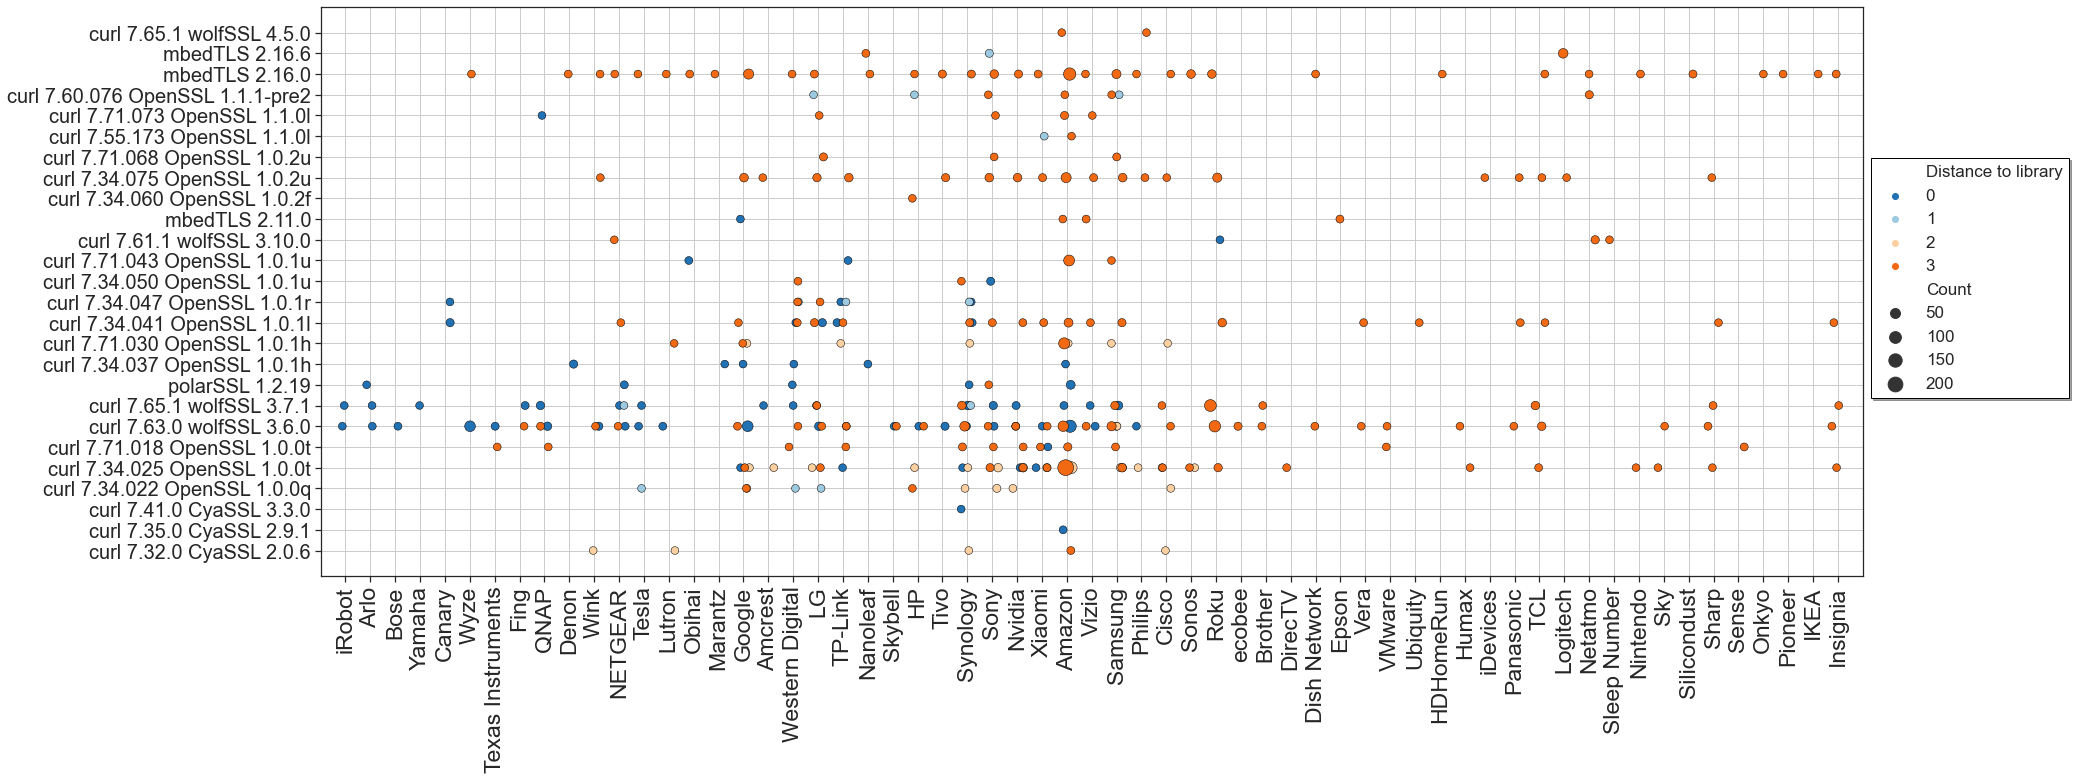

In [64]:
sns.set(style="ticks")

issuer_palette = ["#2171b5", "#9ecae1", "#fdd0a2", "#f16913"]
fig = plt.subplots(figsize=(29, 11))
ax = sns.scatterplot(data=data_scatter, x='jittered', y='version_id', \
                     hue='Distance to library', size='Count', \
                     sizes=(60, 250), edgecolor='black', linewidth=.5, \
                     palette=issuer_palette)

ax.set(xlim=(0, 62))

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles=handles[0:], labels=labels[0:], title="", \
                   bbox_to_anchor=(1, .75), fancybox=False, framealpha=1, shadow=True, borderpad=.4, ncol=1,\
                   fontsize=17, edgecolor='black')
plt.grid()
plt.xlabel("")
plt.ylabel("")
#plt.xticks(rotation=90, fontsize=15)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,\
            26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,\
           48,49,50,51,52,53,54,55,56,57,58,59,60,61], rotation=90, fontsize=22)
ax.set_xticklabels(['iRobot','Arlo','Bose','Yamaha','Canary','Wyze','Texas Instruments',\
                    'Fing','QNAP','Denon','Wink','NETGEAR','Tesla','Lutron','Obihai',\
                    'Marantz','Google','Amcrest','Western Digital','LG','TP-Link','Nanoleaf',\
                    'Skybell','HP','Tivo','Synology','Sony','Nvidia','Xiaomi','Amazon','Vizio',\
                    'Samsung','Philips','Cisco','Sonos','Roku','ecobee','Brother','DirecTV',\
                    'Dish Network','Epson','Vera','VMware','Ubiquity','HDHomeRun','Humax',\
                    'iDevices','Panasonic','TCL','Logitech','Netatmo','Sleep Number','Nintendo',\
                    'Sky','Silicondust','Sharp','Sense','Onkyo','Pioneer','IKEA','Insignia'], \
                    fontsize=23, rotation=90, ha='right', va='center',rotation_mode='anchor')
plt.yticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26], fontsize=19)
ax.set_yticklabels(["curl 7.32.0 CyaSSL 2.0.6", "curl 7.35.0 CyaSSL 2.9.1", "curl 7.41.0 CyaSSL 3.3.0", \
                    "curl 7.34.022 OpenSSL 1.0.0q", "curl 7.34.025 OpenSSL 1.0.0t", "curl 7.71.018 OpenSSL 1.0.0t", \
                    "curl 7.63.0 wolfSSL 3.6.0", "curl 7.65.1 wolfSSL 3.7.1", "polarSSL 1.2.19", \
                    "curl 7.34.037 OpenSSL 1.0.1h", "curl 7.71.030 OpenSSL 1.0.1h", "curl 7.34.041 OpenSSL 1.0.1l", \
                    "curl 7.34.047 OpenSSL 1.0.1r", "curl 7.34.050 OpenSSL 1.0.1u", "curl 7.71.043 OpenSSL 1.0.1u", \
                    "curl 7.61.1 wolfSSL 3.10.0", "mbedTLS 2.11.0", "curl 7.34.060 OpenSSL 1.0.2f", \
                    "curl 7.34.075 OpenSSL 1.0.2u", "curl 7.71.068 OpenSSL 1.0.2u", "curl 7.55.173 OpenSSL 1.1.0l", \
                    "curl 7.71.073 OpenSSL 1.1.0l", "curl 7.60.076 OpenSSL 1.1.1-pre2", \
                    "mbedTLS 2.16.0", "mbedTLS 2.16.6", "curl 7.65.1 wolfSSL 4.5.0"], fontsize=20)
#plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()